## Drifters and Cmems data Notebook

### Introduction
This notebook aims to add the Ekman current components to the geostrophic components. Then, it extracts the inertial current components from drifter data using the spline smoothing filter with the functional approach of Ramsay and Silverman and linear Hanning filter at a 24-hour resolution.


### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 127
  - link : https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.html
  - period : 03-04-2023 to 05-07-2023

- CMEMS Data:
  - Source: Copernicus Marine
  - Collection Frequency: Every 24 hours
  - Data Product:  SEALEVEL_GLO_PHY_L4_MY_008_047 and MULTIOBS_GLO_PHY_MYNRT_015_003
  - link : https://doi.org/10.48670/moi-00148 and https://doi.org/10.48670/mds-00327
  - download data : ahttps://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/download and https://data.marine.copernicus.eu/product/MULTIOBS_GLO_PHY_MYNRT_015_003/download
  - period : 03-04-2023 to 05-07-2023

### Tasks

#### 1. Interpolation CMEMS data

 - Interpolation of geostrophic and Ekman components (DUACS current) over the spatial and temporal grid of the drifter.

#### 2. Total CMEMS currents
 - Adding the surface Ekman current to the geostrophic current.
 -  Using the spline smoothing filter with the functional approach of Ramsay and Silverman at a 24-hour resolution to extract the inertial current components.
 -  conclusion

#### 1. Interpolation CMEMS data

## Import Library

In [73]:
import pandas as pd
import numpy as np
import xarray as xr
import utils as ut
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.interpolate import interp2d

from scipy.signal import medfilt
from scipy.signal import hann, convolve

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation
from scipy.stats import linregress
from scipy.stats import pearsonr

## Read Drifter Data

In [74]:
fn='./drifter_6hour_qc_dc77_616f_005e_U1720625851189.nc';
ds=xr.open_dataset(fn);

## Extract Coordinates and Variables

In [75]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data

In [76]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)
df

,longitude,latitude,time,ve,vn,sst
0,-20.944,-18.263,2023-04-03 00:00:00,-0.04675,-0.03786,26.529
1,-20.948,-18.261,2023-04-03 06:00:00,-0.02040,0.04809,26.483
2,-20.952,-18.245,2023-04-03 12:00:00,-0.08261,0.09331,26.550
3,-20.982,-18.225,2023-04-03 18:00:00,-0.12830,0.04969,26.644
4,-21.004,-18.225,2023-04-04 00:00:00,-0.12047,-0.00368,26.533
...,...,...,...,...,...,...
26468,-22.006,-19.946,2023-06-11 12:00:00,-0.03853,-0.05076,25.189
26469,-22.013,-19.961,2023-06-11 18:00:00,-0.05150,-0.06262,25.179
26470,-22.027,-19.971,2023-06-12 00:00:00,-0.06030,-0.04773,25.133
26471,-22.038,-19.980,2023-06-12 06:00:00,-0.06036,-0.05688,25.093


## Selecting Drifter Data

In [77]:
# Test: Our selected drifter has 813 observations. 
 
df_1 = df[20863:21235]
df_1

,longitude,latitude,time,ve,vn,sst
20863,-22.437,9.085,2023-04-03 00:00:00,-0.05437,-0.08116,27.393
20864,-22.436,9.064,2023-04-03 06:00:00,-0.04568,-0.09848,27.063
20865,-22.455,9.047,2023-04-03 12:00:00,-0.06759,-0.11388,26.890
20866,-22.462,9.020,2023-04-03 18:00:00,-0.07858,-0.08702,27.197
20867,-22.485,9.013,2023-04-04 00:00:00,-0.04339,-0.05212,27.486
...,...,...,...,...,...,...
21230,-22.268,11.538,2023-07-03 18:00:00,-0.01932,-0.05911,29.014
21231,-22.277,11.506,2023-07-04 00:00:00,-0.09729,-0.12572,29.063
21232,-22.307,11.489,2023-07-04 06:00:00,-0.16125,-0.04535,28.997
21233,-22.341,11.489,2023-07-04 12:00:00,-0.15302,0.09805,28.920


# Arrange to begin with index 0

In [78]:
ve_curr_2 = df_1.ve.values
vn_curr_2 = df_1.vn.values
sst_2 = df_1.sst.values
lon_2 = df_1.longitude.values
lat_2 = df_1.latitude.values
time_2 = df_1.time.values

In [79]:
data = {
    'longitude': lon_2,
    'latitude' : lat_2,
    'time'     : time_2,
    've'       : ve_curr_2,
    'vn'       : vn_curr_2,
    'sst'      : sst_2
}

df_2 = pd.DataFrame(data)
df_2

,longitude,latitude,time,ve,vn,sst
0,-22.437,9.085,2023-04-03 00:00:00,-0.05437,-0.08116,27.393
1,-22.436,9.064,2023-04-03 06:00:00,-0.04568,-0.09848,27.063
2,-22.455,9.047,2023-04-03 12:00:00,-0.06759,-0.11388,26.890
3,-22.462,9.020,2023-04-03 18:00:00,-0.07858,-0.08702,27.197
4,-22.485,9.013,2023-04-04 00:00:00,-0.04339,-0.05212,27.486
...,...,...,...,...,...,...
367,-22.268,11.538,2023-07-03 18:00:00,-0.01932,-0.05911,29.014
368,-22.277,11.506,2023-07-04 00:00:00,-0.09729,-0.12572,29.063
369,-22.307,11.489,2023-07-04 06:00:00,-0.16125,-0.04535,28.997
370,-22.341,11.489,2023-07-04 12:00:00,-0.15302,0.09805,28.920


## Now let's interpolate the CMEMS data onto the grid of the drifter data.

### Case of Geostrophic Velocity ugosa and  vgosa

In [80]:
# Loading drifting buoy data from the DataFrame
df_bouees = df_2 
# Suppose your DataFrame contains columns 'time', 'latitude', and 'longitude'

# Loading satellite data from the netCDF file
ds_satellitaires = xr.open_dataset('cmems_obs_mob_glo_phy-cur_my_0.25deg_P1D-m_1720626101580.nc') 
# Suppose your satellite data is stored in variables called 'ugosa' and 'vgosa'

# Extracting satellite current data for the same spatial and temporal positions as the buoys
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_u = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['ugos'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_u.append(courant)

satellitaires_courant_v = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['vgos'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_v.append(courant)

### Case of zonal and meridional ekman Component of 15m deep  current (ue) and (ve)

In [81]:
# Loading drifting buoy data from the DataFrame
df_bouees = df_2
# Suppose your DataFrame contains columns 'time', 'latitude', and 'longitude' 

# Loading satellite wind data from the netCDF file
ds_ek = xr.open_dataset('cmems_obs_mob_glo_phy-cur_my_0.25deg_P1D-m_1720625858521.nc')   
 
# Suppose your satellite wind data is stored in variables called 'eastward_wind' and 'northward_wind'

# Extracting satellite wind data for the same spatial and temporal positions as the buoys
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellite_ue = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_ek['ue'].interp(latitude=lat, longitude=lon, time=time).values
    satellite_ue.append(courant)

satellite_ve = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_ek['ve'].interp(latitude=lat, longitude=lon, time=time).values
    satellite_ve.append(courant)

#### 2. Adding the surface Ekman current to the geostrophic current.
-  Adding the surface Ekman current to the geostrophic current (CMEMS current) and conclusion.

## ugeos plus Ekman zonal current

In [82]:
# u_total = u_geostro + u_e_sat
u_total = [a + b for a, b in zip(satellitaires_courant_u, satellite_ue)]

## vgeos plus Ekman meridional current

In [83]:
# u_total = v_geostro + v_e_sat
v_total = [a + b for a, b in zip(satellitaires_courant_v, satellite_ve)]

## Creation of Pandas Array for CMEMS total current Data

In [84]:
data = {
     
    'u_total'       : u_total,
    'v_total'       : v_total
     
}

dF = pd.DataFrame(data)
dF = dF.astype({'u_total': 'float64', 'v_total': 'float64'})
dF

,u_total,v_total
0,-0.077311,-0.112207
1,-0.077968,-0.104607
2,-0.082764,-0.097861
3,-0.082781,-0.090494
4,-0.086497,-0.088629
...,...,...
367,0.071569,0.093107
368,0.069906,0.091134
369,0.064215,0.075793
370,0.059829,0.062249


## Now Let's Compare Drifter Speeds and  CMEMS Speeds

## Comparison between (ve and u_total) and (vn and v_total)

## Using Regression and Correlation

## case of ve and u_total

Corrélation de Pearson: 0.47371082984438384
Valeur de p (p-value): 3.318009101879195e-22


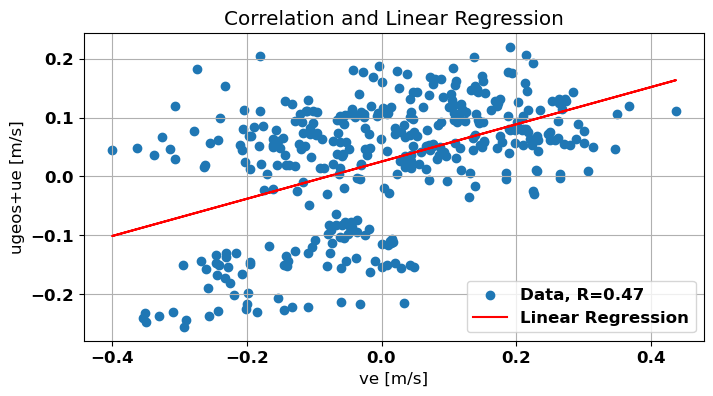

In [85]:
# According to the following, we can simply note that the correlation between "ve" and "ugeos + ue" is 0.81. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = df_2['ve']
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig15 mode.png")
# Show plot
plt.show()

## case of vn and v_total

Corrélation de Pearson: 0.6032518092587197
Valeur de p (p-value): 3.059272218166861e-38


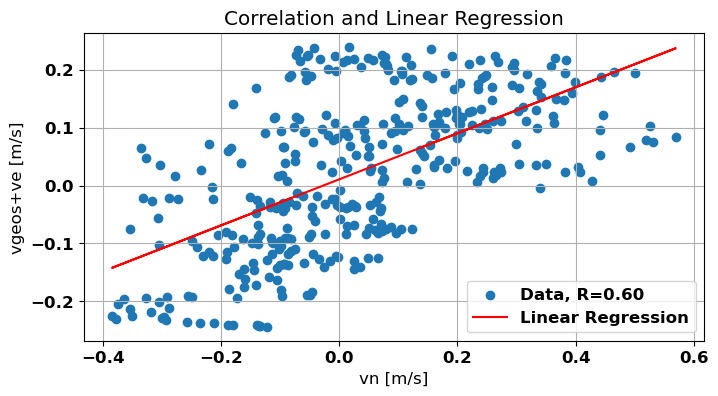

In [86]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.84. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = df_2['vn']
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn [m/s]')
plt.ylabel('vgeos+ve [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig16 mode.png")
# Show plot
plt.show()

# Application of a nonlinear median filter.

## Case of ve and vn

In [87]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['ve'])   

# Apply a median filter with a window size of 3
ve_filter_med = medfilt(current_data, kernel_size=3)

In [88]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['vn'])   

# Apply a median filter with a window size of 3
vn_filter_med = medfilt(current_data, kernel_size=3)

## Comparison between (ve_filter_med and u_total) and (vn_filter_med and v_total) 

## Using Regression and Correlation

## Case of ve_filter_med and u_total

Corrélation de Pearson: 0.48773114881288465
Valeur de p (p-value): 1.2584813628890671e-23


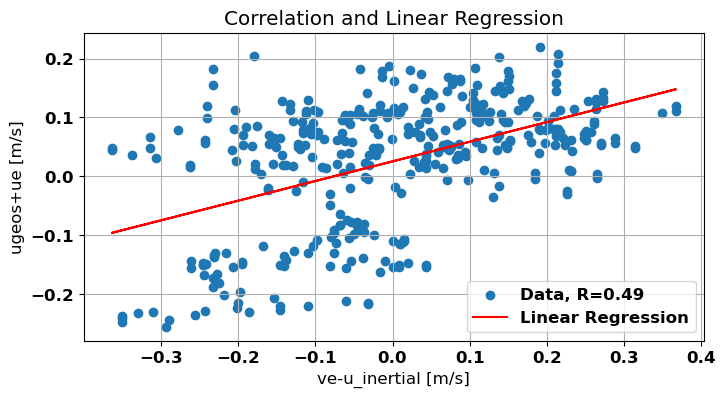

In [89]:
# According to the following, we can simply note that the correlation between "ve_filter" and "ugeos + ue" is 0.81. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = ve_filter_med
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-u_inertial [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig17 mode.png")
# Show plot
plt.show()

## Case of vn_filter_med and v_total

Corrélation de Pearson: 0.6117084594058737
Valeur de p (p-value): 1.483497280567599e-39


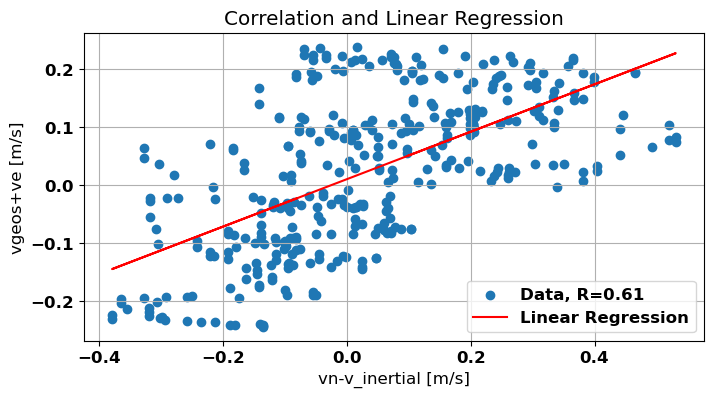

In [90]:
# According to the following, we can simply note that the correlation between "ve_filter" and "ugeos + ue" is 0.81. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = vn_filter_med
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn-v_inertial [m/s]')
plt.ylabel('vgeos+ve [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig18 mode.png")
# Show plot
plt.show()

# Application of a linear Hanning filter at a 24-hour resolution.

## Case of ve

In [91]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['ve'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
ve_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_31136\1390957898.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## Case of vn

In [92]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['vn'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
vn_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_31136\2578851579.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## Comparison between (ve_filter_Han and u_total) and (vn_filter_Han and v_total) 

## Using Regression and Correlation

## Case of ve_filter_Han and u_total

Corrélation de Pearson: 0.8315062721430098
Valeur de p (p-value): 1.7167549534632567e-96


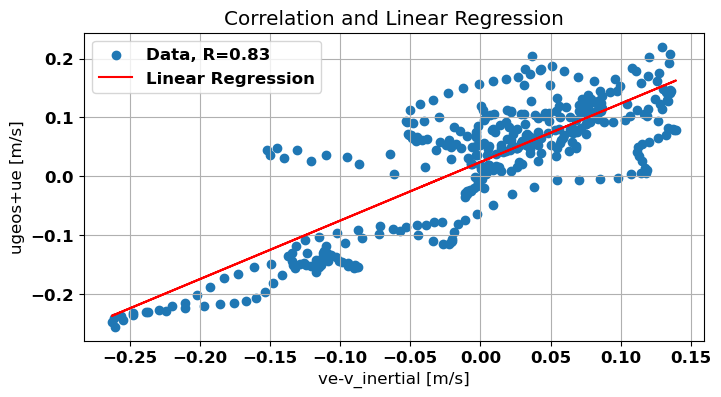

In [93]:
# According to the following, we can simply note that the correlation between "ve_filter" and "ugeos + ue" is 0.81. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = ve_filter_Han
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-v_inertial [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig19 mode.png")
# Show plot
plt.show()

## Case of vn_filter_Han and v_total

Corrélation de Pearson: 0.844082155710967
Valeur de p (p-value): 3.5137209091701187e-102


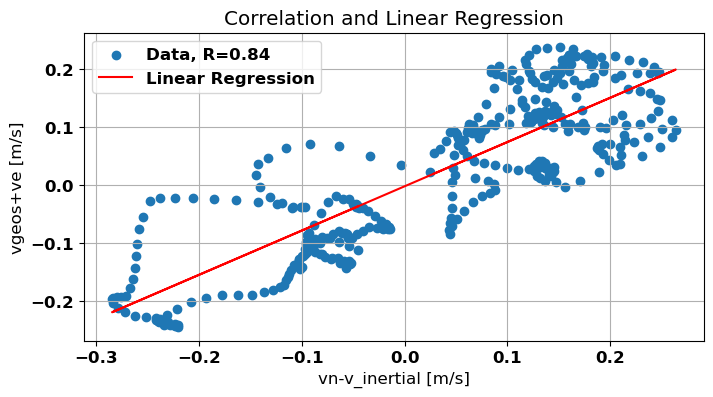

In [94]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.84. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = vn_filter_Han
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn-v_inertial [m/s]')
plt.ylabel('vgeos+ve [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig20 mode.png")
# Show plot
plt.show()

## Spline smoothing using the functional approach of Ramsay and Silverman.

## Case of ve and vn

In [95]:
# Lissage par splines avec l'approche fonctionnelle de Ramsay et Silverman
# ce code utilise la méthode LOWESS(Locally Weighted Scatterplot Smoothing) pour ajuster localement les données de vitesse par rapport au temps, en appliquant un 
# lissage qui prend en compte les relations locales entre les points. Cela permet de réduire le bruit tout en conservant les tendances générales et les contours
# nets des données originales, selon le paramètre frac spécifié.

lowess = sm.nonparametric.lowess(df_2['ve'], df_2['time'], frac=0.01)

temps_smoothed = lowess[:, 0]
vitesse_smoothed_ve = lowess[:, 1]

lowess = sm.nonparametric.lowess(df_2['vn'], df_2['time'], frac=0.01)

temps_smoothed = lowess[:, 0]
vitesse_smoothed_vn = lowess[:, 1]

## New comparison between (ve_filter and u_total) and (vn_filter and v_total) 

## ve_filter and u_total

Corrélation de Pearson: 0.47371082984438384
Valeur de p (p-value): 3.318009101879195e-22


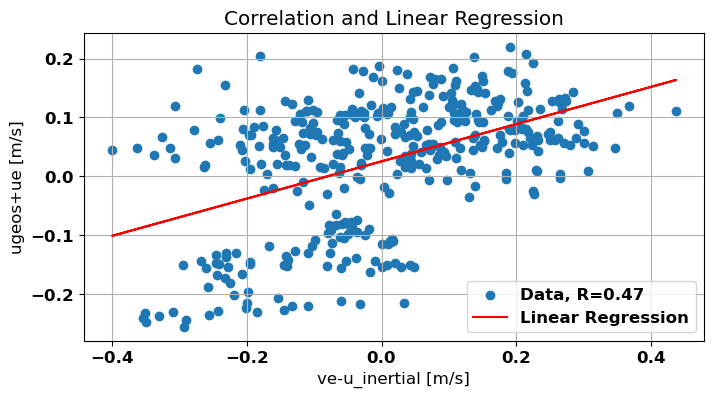

In [96]:
# According to the following, we can simply note that the correlation between "ve_filter" and "ugeos + ue" is 0.83. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = vitesse_smoothed_ve
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-u_inertial [m/s]')
plt.ylabel('ugeos+ue [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig21 mode.png")
# Show plot
plt.show()

## vn_filter and v_total

Corrélation de Pearson: 0.6032518092587197
Valeur de p (p-value): 3.059272218166861e-38


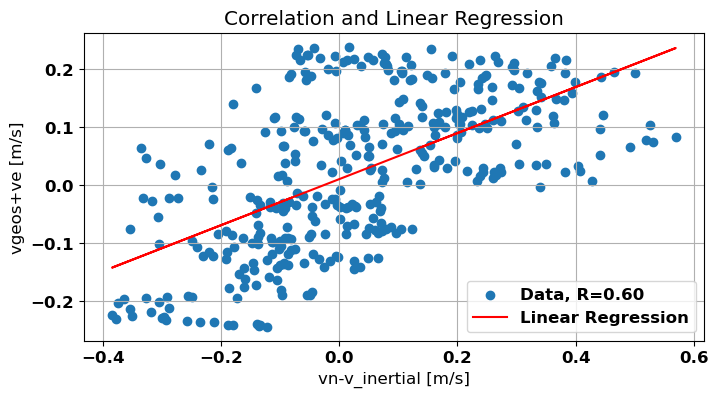

In [97]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.86. 
# This means that there is a positive and strong relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = vitesse_smoothed_vn
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn-v_inertial [m/s]')
plt.ylabel('vgeos+ve [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
plt.savefig("fig22 mode.png")
# Show plot
plt.show()

### Resume

### Zonal components currents

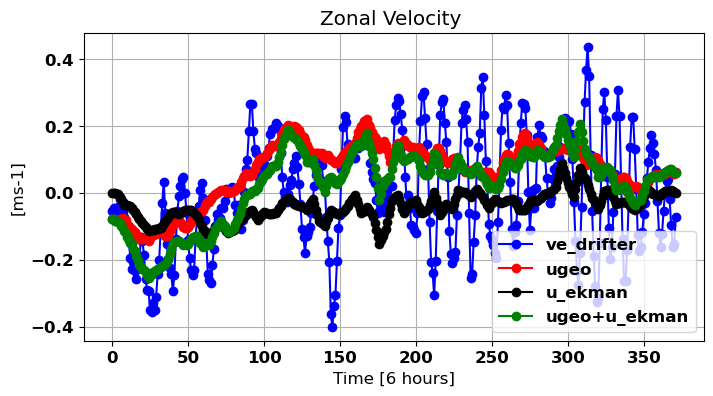

In [98]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(df_2['ve'],marker='o', linestyle='-', color='blue',label='ve_drifter')
plt.plot(satellitaires_courant_u,marker='o', linestyle='-', color='red',label='ugeo')
plt.plot(satellite_ue,marker='o', linestyle='-', color='k',label='u_ekman')
plt.plot(dF['u_total'],marker='o', linestyle='-', color='g',label='ugeo+u_ekman')

plt.title('Zonal Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig23 mode.png")
plt.show()

### Meridional components currents

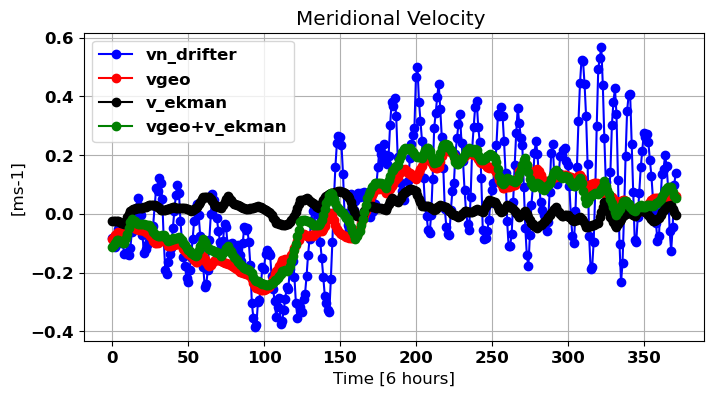

In [99]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(df_2['vn'],marker='o', linestyle='-', color='blue',label='vn_drifter')
plt.plot(satellitaires_courant_v,marker='o', linestyle='-', color='red',label='vgeo')
plt.plot(satellite_ve,marker='o', linestyle='-', color='k',label='v_ekman')
plt.plot(dF['v_total'],marker='o', linestyle='-', color='g',label='vgeo+v_ekman')

plt.title('Meridional Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig24 mode.png")
plt.show()

# Application of a linear Hanning filter at a 24-hour resolution.

### Zonal components currents

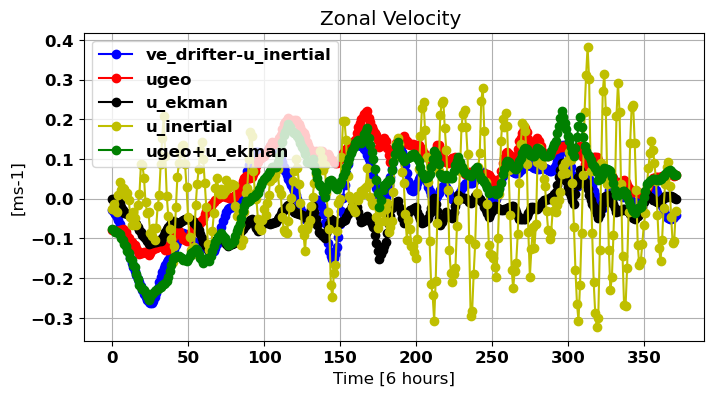

In [100]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(ve_filter_Han, marker='o', linestyle='-', color='blue',label='ve_drifter-u_inertial')
plt.plot(satellitaires_courant_u,marker='o', linestyle='-', color='red',label='ugeo')
plt.plot(satellite_ue,marker='o', linestyle='-', color='k',label='u_ekman')
plt.plot(df_2['ve']-ve_filter_Han, marker='o', linestyle='-', color='y',label='u_inertial')
plt.plot(dF['u_total'],marker='o', linestyle='-', color='g',label='ugeo+u_ekman')

plt.title('Zonal Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig25 mode.png")
plt.show()

### Meridional components currents

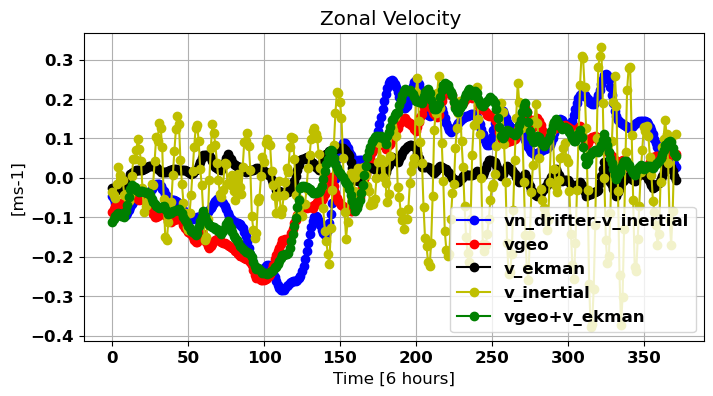

In [101]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(vn_filter_Han, marker='o', linestyle='-', color='blue',label='vn_drifter-v_inertial')
plt.plot(satellitaires_courant_v,marker='o', linestyle='-', color='red',label='vgeo')
plt.plot(satellite_ve,marker='o', linestyle='-', color='k',label='v_ekman')
plt.plot(df_2['vn']-vn_filter_Han, marker='o', linestyle='-', color='y',label='v_inertial')
plt.plot(dF['v_total'],marker='o', linestyle='-', color='g',label='vgeo+v_ekman')

plt.title('Zonal Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig26 mode.png")
plt.show()

## Conclusion
-  Strong correlation between drifter currents and altimetry currents (CMEMS Current).
-  Total altimetric zonal component slightly dominated by the total zonal component.